In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
from gurobipy import GRB, quicksum
import torch

In [2]:
class QuadraticObj:
    
    def __init__(self, d=20, hidden_d=10):
        self.dim = d
        self.quadratic = np.random.randn(d,hidden_d)
        self.quadratic = np.matmul(self.quadratic, self.quadratic.T)
        self.linear = np.random.randn(d,1)
    
    def value_oracle(self, x):
        x_re = x.reshape(1,self.dim)
        obj = np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear)
        return obj[0][0]
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.reshape(1,self.dim) for x in x_list]
        value_list = [(np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear))[0][0] for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):   
        tensor_x = torch.tensor(x, requires_grad = True)
        x_re = tensor_x.reshape(1,self.dim)
        obj = torch.matmul(torch.matmul(x_re,torch.tensor(self.quadratic)), x_re.T) + torch.matmul(x_re, torch.tensor(self.linear))
        obj.backward()
        return tensor_x.grad.numpy()

    
    
class NonConvexObj:
    
    def __init__(self, d=20):
        self.dim = d
    
    def value_oracle(self, x):
        x_re = x.copy()
        obj = np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2)
        return obj
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.copy() for x in x_list]
        value_list = [np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2) for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):
        tensor_x = torch.tensor(x, requires_grad = True)
        obj = torch.sum(100 * ((tensor_x[1:] - (tensor_x[:-1] ** 2))**2) + (1-tensor_x[:-1]) ** 2)
        obj.backward()
        return tensor_x.grad.numpy()

In [3]:
dim  = 100

In [4]:
objective = QuadraticObj(d=dim,hidden_d=dim//2)

In [175]:
objective = NonConvexObj(d=dim)

In [176]:
initial = np.random.randn(objective.dim)
total_steps = 100
reps = 10
line_search = 4
query_num = 10

In [177]:
# rank-based optimization
def grad_est_from_rank(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
    relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
    weight = np.zeros(len(query_list))
    if with_order:
        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                weight[x1] += 1
                weight[x0] -= 1


    grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))],axis=0)
    return grad_est/np.linalg.norm(grad_est)

# def grad_est_from_rank(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
#     Z = []
#     y = []
#     if with_order:
#         for ii, x0 in enumerate(query_rank[:-1]):
#             for jj, x1 in enumerate(query_rank[(ii+1):]):
#                 now_z = query_list[x1]-query_list[x0]
#                 Z.append(now_z)
#                 y.append(1)
#     if len(query_list) > len(query_rank):
#         for x0, qx0 in enumerate(query_list):
#             if x0 not in query_rank:
#                 for top_x0 in query_rank:
#                     now_z = qx0 - query_list[top_x0]
#                     Z.append(now_z)
#                     y.append(1)
    
#     y=np.array(y)
#     Z=np.array(Z)
#     #print(Z.shape)
#     #grad_est = Solve1BitCS(y,Z,Z.shape[0],Z.shape[1],sparsity)
#     grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
#     return grad_est/np.linalg.norm(grad_est)

total_zo_rank_hist = []

zo_rank_grad_hist = []

for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    top = query_num + 1
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_rank_hist= []

    with_order = True

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, top)
        grad_est = grad_est_from_rank(query_list,query_rank,sparsity,mu,with_order)
        
        true_grad = objective.gradient_oracle(query_list[query_rank[0]])
        true_grad /= np.linalg.norm(true_grad)
        zo_rank_grad_hist.append(np.dot(grad_est,true_grad))
        
        
        if line_search > 0:
            line_search_candidates = [query_list[query_rank[0]] - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            x = line_search_candidates[objective.rank_oracle(line_search_candidates)[0]]
        else:
            x = query_list[query_rank[0]] - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_rank_hist.append(cur_obj)
    total_zo_rank_hist.append(zo_rank_hist)

In [185]:
# es-like direction
def grad_est_from_rank_es_like(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
    relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
    weight = np.sign(relative_rank - relative_rank[0]) * np.power(np.abs(relative_rank - relative_rank[0]),1)
    #print(weight)
    
    grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))],axis=0)
    
    return grad_est/np.linalg.norm(grad_est) if np.linalg.norm(grad_est)>1e-4 else grad_est

total_zo_rank_es_like_hist = []

zo_rank_grad_es_like_hist = []
query_num = 10
for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)

    top = query_num+1
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_rank_es_like_hist= []

    with_order = True

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, top)
        grad_est = grad_est_from_rank_es_like(query_list,query_rank,sparsity,mu,with_order)
        
        true_grad = objective.gradient_oracle(query_list[query_rank[0]])
        true_grad /= np.linalg.norm(true_grad)
        zo_rank_grad_es_like_hist.append(np.dot(grad_est,true_grad))
        
        
        if line_search > 0:
            line_search_candidates = [query_list[query_rank[0]] - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            x = line_search_candidates[objective.rank_oracle(line_search_candidates)[0]]
        else:
            x = query_list[query_rank[0]] - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_rank_es_like_hist.append(cur_obj)
    total_zo_rank_es_like_hist.append(zo_rank_es_like_hist)

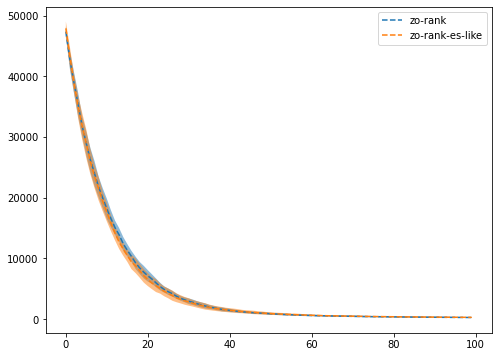

In [186]:

plt.figure(figsize=(8,6))


total_zo_rank_hist = np.array(total_zo_rank_hist)
total_zo_rank_mean = total_zo_rank_hist.mean(0)
total_zo_rank_std = total_zo_rank_hist.std(0)
plt.plot(total_zo_rank_mean,"--", label = "zo-rank")
plt.fill_between(np.arange(total_steps),total_zo_rank_mean - total_zo_rank_std,total_zo_rank_mean + total_zo_rank_std, alpha=0.5)

total_zo_rank_es_like_hist = np.array(total_zo_rank_es_like_hist)
total_zo_rank_es_like_mean = total_zo_rank_es_like_hist.mean(0)
total_zo_rank_es_like_std = total_zo_rank_es_like_hist.std(0)
plt.plot(total_zo_rank_es_like_mean,"--", label = "zo-rank-es-like")
plt.fill_between(np.arange(total_steps),total_zo_rank_es_like_mean - total_zo_rank_es_like_std,total_zo_rank_es_like_mean + total_zo_rank_es_like_std, alpha=0.5)

plt.legend()

In [139]:
ry

array([-0.02429106, -0.00174422, -0.05362463,  0.07362146,  0.19468264,
        0.02686209,  0.05451651,  0.28551475,  0.15139335, -0.08097029,
        0.        ])

In [5]:
dim=10
m=10
x = np.random.rand(dim,1)
x = x/np.linalg.norm(x)
reps = 100000


In [6]:
re_x = []
for _ in range(reps):
    Z = np.random.randn(m,dim)
    #Z /= np.linalg.norm(Z,axis=1).reshape(m,-1)
    Z = np.concatenate([np.zeros((1,dim)),Z],0)
    ry = np.matmul(Z,x).flatten()
    y_rank = np.argsort(ry)
    
    relative_rank = np.array([np.where(y_rank==ii)[0][0]+1 for ii in range(len(y_rank))])
    weight =ry#relative_rank - relative_rank[0] # np.sign(relative_rank - relative_rank[0]) * np.power(np.abs(relative_rank - relative_rank[0]),3)
    #weight[weight<0] = -1
    now_rex = np.sum([(Z[ii])*weight[ii] for ii in range(1,len(y_rank))],axis=0)
    re_x.append(now_rex/np.linalg.norm(now_rex))
    #re_x.append(Solve1BitCS(y,Z,m,dim,10000))
#print(np.linalg.norm(x.flatten()-re_x/reps))

mean_re_x = np.zeros(dim)
results_rank = []
for n in range(1,reps+1):
    mean_re_x += re_x[n-1] 
    if n in [1,10,100,1000,10000,100000]:
        test_x = mean_re_x/n
        test_x /= np.linalg.norm(test_x)
        results_rank.append(np.linalg.norm(x.flatten()-test_x))
        
#plt.plot(results,label="w/o rank")


In [9]:
re_x = []
for _ in range(reps):
    Z = np.random.randn(m,dim)
    #Z /= np.linalg.norm(Z,axis=1).reshape(m,-1)
    Z = np.concatenate([np.zeros((1,dim)),Z],0)
    ry = np.matmul(Z,x).flatten()
    y_rank = np.argsort(ry)
    
    relative_rank = np.array([np.where(y_rank==ii)[0][0]+1 for ii in range(len(y_rank))])
    weight =-(np.sign(relative_rank - relative_rank[0])   * np.power(np.abs(relative_rank - relative_rank[0]),3))
    
    #weight[weight<0] = -1
    now_rex = np.sum([(Z[ii])*weight[ii] for ii in range(1,len(y_rank))],axis=0)
    re_x.append(now_rex/np.linalg.norm(now_rex))
    #re_x.append(Solve1BitCS(y,Z,m,dim,10000))
#print(np.linalg.norm(x.flatten()-re_x/reps))

mean_re_x = np.zeros(dim)
results_rank2 = []
for n in range(1,reps+1):
    mean_re_x += re_x[n-1] 
    if n in [1,10,100,1000,10000,100000]:
        test_x = mean_re_x/n
        test_x /= np.linalg.norm(test_x)
        results_rank2.append(np.linalg.norm(x.flatten()-test_x))
        
#plt.plot(results,label="w/o rank")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.6539266964734868, 0.1804762344667992, 0.09484698247814582, 0.031236900066841492, 0.01244080162539588, 0.0022506064551677894]


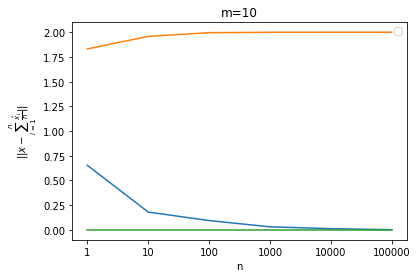

In [10]:
plt.plot(results_rank)
plt.plot(results_rank2)
plt.plot(np.zeros_like(results_rank))
plt.title("m=10")
plt.xlabel("n")
plt.legend()
plt.ylabel(r"$||x-\sum_{i=1}^n \frac{\hat x_i}{n}||$")
plt.xticks([0,1,2,3,4,5],[1,10,100,1000,10000,100000])
print(results_rank)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.6539266964734868, 0.1804762344667992, 0.09484698247814582, 0.031236900066841492, 0.01244080162539588, 0.0022506064551677894]


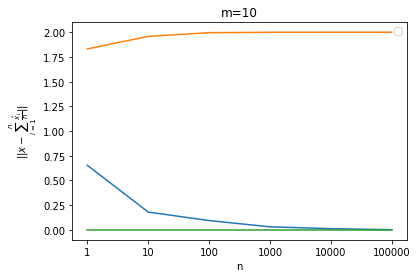

In [11]:
plt.plot(results_rank)
plt.plot(results_rank2)
plt.plot(np.zeros_like(results_rank))
plt.title("m=10")
plt.xlabel("n")
plt.legend()
plt.ylabel(r"$||x-\sum_{i=1}^n \frac{\hat x_i}{n}||$")
plt.xticks([0,1,2,3,4,5],[1,10,100,1000,10000,100000])
print(results_rank)

In [209]:
ny=np.sum([(Z[ii])*weight[ii] for ii in range(1,len(y_rank))],axis=0)
ny /= np.linalg.norm(ny)
np.linalg.norm(x.flatten()-ny)

1.1054021690386822

In [16]:
results_rank

[0.43917848419570665,
 0.18875115130873457,
 0.031935022325389244,
 0.03311122285606889,
 0.0053900007215435235,
 0.0012060872340957831]

In [193]:
ny1=np.sum([(Z[ii])*ry[ii] for ii in range(1,len(y_rank))],axis=0)
ny1 /= np.linalg.norm(ny1)
np.linalg.norm(x.flatten()-ny1)

0.004840020956156981

In [174]:
weight/np.linalg.norm(weight)

array([ 0.        , -0.00067697, -0.00283737, ...,  0.00190659,
       -0.0029444 ,  0.0037044 ])

In [173]:
ry/np.linalg.norm(ry)

array([ 0.        , -0.00049795, -0.00220957, ...,  0.00144414,
       -0.0023135 ,  0.00315205])